# Word Mover’s Distance

This notebook implements the **Word Mover's Distance (WMD)** as described in **[From Word Embeddings To Document Distances](http://proceedings.mlr.press/v37/kusnerb15.pdf)** by Matt Kusner, Yu Sun, Nicholas Kolkin and Kilian Weinberger.

## WMD
### Definition

The  **WMD**  measures the dissimilarity between two text documents as the minimum amount of distance that the  embedded  words  of  one  document  need  to “travel” to reach the embedded words of another document.

 ![](https://raw.githubusercontent.com/mkusner/wmd/master/fig1.png)
Image credit: [Matt J. Kusner Github repo](https://github.com/mkusner/wmd)

The problem is formulated as a transportation problem that is the minimal cumulative cost of moving $d$ to $d'$ given constraints. The solution is provided by the following linear program: 

$$\min_{T \geq 0} \sum_{i,j=1}^{n} T_{ij}c(i,j)$$

subject to $$  \sum_{j=1}^{n} T_{ij} = d_i,  \forall i \in \{1, ..., n\} $$
$$  \sum_{i=1}^{n} T_{ij} = d'_i,  \forall j \in \{1, ..., n\} $$

### Problem 

This solution is exact but requires heavy computations and usually uses solvers that solve a **special case** of the **Earth Mover's Distance**.

As such, this notebook will go through several **faster approximate ways of computing WMD**.

# Implementation

## Importing libraries

We'll be using a few libraries to help with the implemention:

* **Gensim**: Preprocessing, word2vec, nBOW and the wmdistance function
* **Numpy**:  General numerical computing
* **Matplotlib**: Display curves and perf statistics
* **Time/Timeit**: Timing and benchmarks

In [1]:
import gensim.parsing.preprocessing as genproc

from gensim.utils import deaccent
from gensim.models import KeyedVectors
from gensim.models.normmodel import NormModel
from gensim import corpora

import numpy as np

import time
import timeit

C:\Users\cpcdo\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Sentences

Let's load a few documents containing sentences that we'll use throughout this notebook.

In [2]:
f_strs = open("data/test_sentences.txt", "r", encoding='utf-8')
strs = [str for str in f_strs.readlines()]

## Preprocessing

This section preprocesses the text so that it can be used for our computations

### Stopwords, punctuation, spaces removal

Stopwords are words which are filtered out which do not really contribute to the meaning of a sentence. Stopwords examples are:

* “the”
* “a”
* “an”
* “in”
* [and many more (here's an example list)](https://gist.github.com/sebleier/554280)

We also remove every other unnecessary things from the text like whitespaces, punctuation, short words, etc. 

In [3]:
proc = [genproc.remove_stopwords, 
    genproc.strip_tags,
    genproc.strip_punctuation,
    genproc.strip_multiple_whitespaces,
    genproc.strip_numeric,
    genproc.remove_stopwords,
    genproc.strip_short,
    deaccent]
    #genproc.stem_text]

def apply_lambdas(x, lambdas):
    return [p(x) for p in lambdas][-1]

In [4]:
strs_proc = [genproc.preprocess_string(str, proc) for str in strs]

## nBOW

Normalized Bag-of-word (nBOW) vectors, $d \in \mathbb{R}^n$ are defined as follows:

$$d_i = \frac{c_i}{\sum_{j=1}^{n} c_j}$$

Here we get $c_i$ for each word which means that we only get the BOWs:

In [5]:
dict = corpora.Dictionary()
bows = [dict.doc2bow(str, allow_update=True) for str in strs_proc]

Finally we normalize the BOWs:

In [6]:
# Transform nBOWs to non-tuples and flatten
def get_from_tuples(tuples, i, bows=bows):
    l = [[t[1]] * b[1] for (b, t) in zip(bows[i], tuples)]
    return [x for sub in l for x in sub]

In [7]:
# Use L1 norm to match the paper
# L2 norm was default
norm_model = NormModel(norm='l1')
nbows = [get_from_tuples(norm_model.normalize(bows[i]), i) for i in range(len(strs_proc))]

## word2vec

We load word2vec weights pretrained on Google News

In [8]:
model = KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary=True)

Precompute L2-normalized vectors

In [9]:
model.init_sims(replace=True)

### Distances cache

Taking advantage of the symmetry of distances can be a good way to speed up distance computation.

$$c(i, j) = c(j, i)$$

Here we create a distance cache using a dict that support the following operation:

$$dict[(i, j)] = dict[(j, i)]$$

This enables us to actually only compute the upper or lower triangular matrix of distances. In practice this is going to be a mix of both lower and upper but the total number of distances computed will be equal to the number of element of a triangular part of the matrix.


\begin{bmatrix}
  0 & \cdots & \cdots & \cdots & dist(1, n) \\
  & dist(2, 1) & \cdots & \cdots & dist(2, n) \\
  & \ddots & \cdots & \cdots & \vdots \\
  & & \ddots & \cdots & \vdots \\
  & & & \ddots & \vdots \\
  & & & & 0
 \end{bmatrix}

In [10]:
class tri_dict():
    def __init__(self):
        self.dict = {}
    def __len__(self):
        return self.dict.__len__(self) / 2

    def __setitem__(self, key, value):
        self.dict.__setitem__(key, value)
        
    # Tries retrieving either (i, j) or (j, i)
    def __getitem__(self, key):
        g = self.dict.get(key)
        if g == None:
            g = self.dict.get((key[1], key[0]))
        return g

dists = tri_dict()

Here's another version of this dict that actually uses the full matrix. We'll see later how this affects performance

In [12]:
class tri_dict_full_mem():
    def __init__(self):
        self.dict = {}
    def __len__(self):
        return self.dict.__len__(self) / 2

    # Insert (i,j) and (j, i) in one go
    def __setitem__(self, key, value):
        self.dict.__setitem__((key[0], key[1]), value)
        self.dict.__setitem__((key[1], key[0]), value)
        
    def __getitem__(self, key):
        return self.dict.get(key)

dists = tri_dict_full_mem()

*Note: You can use one or the other*

## Word Centroid Distance (WCD)

According to the paper, the WCD between documents $d$ and $d'$ must lower bound their WMD. As such, WCD is defined as follows:

$$WCD(d, d') = \left\lVert Xd - Xd' \right\rVert_2$$

In the code, a centroid is computed as follows: 
$$X^T.d$$

In [13]:
def get_centroid(doc):
    X = np.array([model[str] for str in strs_proc[doc]])
    d = np.array(nbows[doc])
    
    # X^T.d
    return X.T.dot(d)

Here we compute the Euclidean distance as follows:
$$ c(q, p) = c(p, q) = \sqrt{(q_1-p_1)^2 + (q_2-p_2)^2 + \cdots + (q_n-p_n)^2}  = \sqrt{\sum_{i=1}^n (q_i-p_i)^2}.$$

In [122]:
# Euclidean distance
def dist(x, y, i, j):
    return np.sqrt(np.sum((x - y)**2))

Here we do the same but we only compute the distance when it hasen't been cached yet

In [14]:
# Euclidean distance with dict cache
def dist(x, y, i, j):
    d = dists[(i, j)]
    # Only compute if not cached
    if d == None:
        d = np.sqrt(np.sum((x - y)**2))
        # Cache it for later
        dists[(i, j)] = d
    return d

*Note: You can use one or the other distance function depending on if you want caching or not*

The actual WCD in our code is:
$$WCD(doc1, doc2) = \left\lVert c1 - c2 \right\rVert_2$$

Here's pseudo-code for the WCD implementation:

```
        function wcd:
            doc1 <- document 1 id
            doc2 <- document 2 id
        begin:
            c1 <- compute centroid of doc1
            c2 <- compute centroid of doc2
            
            return Euclidean distance between c1 and c2
        end
```

**Complexity: $O(dp)$**, where $d$ is the embedding size and $p$ the number of unique words in the documents.


In [15]:
def wcd(doc1, doc2):
    # Compute centroids
    c1 = get_centroid(doc1)
    c2 = get_centroid(doc2)
    # Return distance between centroids
    return dist(c1, c2, doc1, doc2)

### Usage

In [124]:
[wcd(0, i) for i in range(len(nbows))]

[0.0,
 0.4889688754349564,
 0.6282021317744428,
 0.607863411337698,
 0.6216390672798184,
 0.5685506211966792,
 0.634117029062517,
 0.6086501006435308,
 2.294856610359048,
 0.8530214259104537,
 0.8912037390990674,
 0.8495958119706942,
 0.740203290171906,
 0.6066595381454836,
 0.765175278237766,
 0.6506489116202538,
 0.6153644479910629,
 0.7279378379077874,
 0.6405168303900033,
 0.6178455141858197,
 0.5810393113521084,
 0.679971016715287]

## Relaxed WMD

Relaxed WMD actually, like its name implies, relaxes the original *WMD* optimization problem and it achieves this by removing one of the two constrainsts, each at a time, and optimizing.

This can be written the first time as:

$$\min_{T \geq 0} \sum_{i,j=1}^{n} T_{ij}c(i,j)$$
    subject to $$  \sum_{j=1}^{n} T_{ij} = d_i,  \forall i \in \{1, ..., n\} $$

And then we can write it again as:

$$\min_{T \geq 0} \sum_{i,j=1}^{n} T_{ij}c(i,j)$$
    subject to $$  \sum_{i=1}^{n} T_{ij} = d'_i,  \forall j \in \{1, ..., n\} $$

This can be achieved by actually only computing a problem and then reversing this same problem in the other direction.

During the implementation of *RWMD*, I came up with 3 different implementations as I was trying to optimize for performances while keeping the same output.

1) The first implementation computes distances on the fly and then takes the minimum out of these for the current document. The problem is reversed just after.

This implementation is the slowest.

In [16]:
def rwmd_implem_1(doc1, doc2):
    X = model
    idx = 0
    rwmd1 = 0
    # Without second optimization constraint
    for j in strs_proc[doc1]:
        c_ij = [dist(X[j], X[i], i, j) for i in strs_proc[doc2]]
        rwmd1 += min(c_ij) * nbows[doc1][idx]
        idx += 1
    idx = 0
    rwmd2 = 0
    # Without first optimization constraint
    for j in strs_proc[doc2]:
        c_ij = [dist(X[j], X[i], i, j) for i in strs_proc[doc1]]
        rwmd2 += min(c_ij) * nbows[doc2][idx]
        idx += 1
        
    return max(rwmd1, rwmd2)

2) This very classic loop-based implementation is surprisingly faster than the first implementation.

This is because we precompute distances first and then we don't need to do any lookup later on.

In [17]:
def rwmd_implem_2(doc1, doc2):
    doc1_len = len(nbows[doc1])
    doc2_len = len(nbows[doc2])
    doc1_dists = np.ones(doc1_len) * float('inf')
    doc2_dists = np.ones(doc2_len) * float('inf')
    
    dists = np.array([[dist(model[i], model[j], i, j) for j in strs_proc[doc2]] for i in strs_proc[doc1]])
    
    for word1_index in range(doc1_len):
        word1 = strs_proc[doc1][word1_index]
        for word2_index in range(doc2_len):
            word2 = strs_proc[doc2][word2_index]
            wdist = dists[word1_index][word2_index] 
            
            if wdist < doc1_dists[word1_index]:
                doc1_dists[word1_index] = wdist
            if wdist < doc2_dists[word2_index]:
                doc2_dists[word2_index] = wdist
    
    rwmd1 = np.sum(doc1_dists * nbows[doc1])
    rwmd2 = np.sum(doc2_dists * nbows[doc2])
    rwmd = max(rwmd1, rwmd2)
    return rwmd

3) The third implementation is the fastest as it precomputes distances and uses vectorization and *Numpy* as much as possible.

We'll be giving the pseudocode for this implementation only as it is the fastest.

Here's pseudo-code for the RWMD implementation:

```
        function rwmd:
            doc1 <- document 1 id
            doc2 <- document 2 id
        begin:
            dists <- Precompute all distances
        
            // This is equivalent to computing j∗ = argmin(i, j) for each i
            c_ij <- brute force nearest neighnor search around i among all j
            rwmd1 <- dot product between c_ij and nBOW of document 1
            
            // Now, we do exactly the same thing but reversed
            
            // This is equivalent to computing i∗ = argmin(i, j) for each 
            c_ij <- brute force nearest neighnor search around j among all i
            rwmd1 <- dot product between c_ij and nBOW of document 2
            
            return the tightest bound by computing max(rwmd1, rwmd2)
        end
```

**Complexity: $O(p^2)$**, where $p$ is the number of unique words in the documents.


In [18]:
def rwmd(doc1, doc2):
    doc1_len = len(nbows[doc1])
    doc2_len = len(nbows[doc2])
    
    # Precompute all distances
    dists = np.array([[dist(model[i], model[j], i, j) for j in strs_proc[doc2]] for i in strs_proc[doc1]])
    
    # Without second optimization constraint
    c_ij = np.array([np.min([dists[i][j] for j in range(doc2_len)]) for i in range(doc1_len)])
    rwmd1 = np.dot(c_ij, nbows[doc1])
    
    # Without first optimization constraint
    c_ij = np.array([np.min([dists[j][i] for j in range(doc1_len)]) for i in range(doc2_len)])
    rwmd2 = np.dot(c_ij, nbows[doc2])
    
    return max(rwmd1, rwmd2)

### Usage

In [126]:
[rwmd_implem_1(0, j) for j in range(len(nbows))]

[0.0,
 1.0618066430091857,
 1.3466628619602747,
 1.3384341543371028,
 1.5745622590184212,
 1.6217780970945592,
 2.0408487006237634,
 2.1576749499963253,
 3.3718802332878113,
 1.3447080850601196,
 1.3566317558288574,
 1.3516850173473358,
 1.3274114429950714,
 1.3285035490989685,
 1.3340416848659515,
 1.336386799812317,
 1.7221189198955411,
 1.341009497642517,
 1.2823150591416792,
 1.7546531072882716,
 1.529034259142699,
 2.212308130985082]

In [30]:
[rwmd_implem_2(0, j) for j in range(len(nbows))]

[0.0,
 1.0618066430091857,
 1.3466628619602747,
 1.3384341543371028,
 1.5745622590184212,
 1.621778097094559,
 2.040848700623763,
 2.1576749499963253,
 3.3718802332878113,
 1.3447080850601196,
 1.3566317558288574,
 1.3516850173473358,
 1.3274114429950714,
 1.3285035490989683,
 1.3340416848659515,
 1.336386799812317,
 1.7221189198955411,
 1.341009497642517,
 1.2823150591416792,
 1.7546531072882718,
 1.5290342591426989,
 2.2123081309850825]

In [31]:
[rwmd(0, j) for j in range(len(nbows))]

[0.0,
 1.0618066430091857,
 1.3466628619602747,
 1.3384341543371028,
 1.5745622590184212,
 1.621778097094559,
 2.040848700623763,
 2.1576749499963253,
 3.3718802332878113,
 1.3447080850601196,
 1.3566317558288574,
 1.3516850173473358,
 1.3274114429950714,
 1.3285035490989685,
 1.3340416848659515,
 1.336386799812317,
 1.7221189198955411,
 1.341009497642517,
 1.2823150591416792,
 1.7546531072882718,
 1.5290342591426989,
 2.2123081309850825]

In [32]:
[wcd(0, j) for j in range(len(nbows))]

[0.0,
 0.4889688754349564,
 0.6282021317744428,
 0.607863411337698,
 0.6216390672798184,
 0.5685506211966792,
 0.634117029062517,
 0.6086501006435308,
 2.294856610359048,
 0.8530214259104537,
 0.8912037390990674,
 0.8495958119706942,
 0.740203290171906,
 0.6066595381454836,
 0.765175278237766,
 0.6506489116202538,
 0.6153644479910629,
 0.7279378379077874,
 0.6405168303900033,
 0.6178455141858197,
 0.5810393113521084,
 0.679971016715287]

In [33]:
[model.wmdistance(strs_proc[0], strs_proc[j]) for j in range(len(nbows))]

[0.0,
 1.064594336759162,
 1.3496657413730007,
 1.3449191373622853,
 1.3251857828273477,
 1.3280674600887181,
 1.3242448895635275,
 1.3229613969767622,
 1.3779413764327169,
 1.3515102978463174,
 1.361813734663129,
 1.356589825306803,
 1.3329633577233069,
 1.3359622712908688,
 1.338013213535734,
 1.338700849033177,
 1.3339357248328365,
 1.3578414765372275,
 1.2851774315077849,
 1.3284418756421288,
 1.326301286976676,
 1.323848357715634]

## Prefetch and Prune

This final method is actually just a way of using everything that we made before and all we know about these methods compared to the exact *WMD*.

We know that *WCD* lower bounds the *WMD* between the two documents. We also know that *RWMD* also lower bounds the exact *WMD* but more tightly.

*WCD* is also way cheaper than *RWMD* which is in turn cheaper than exact *WMD*.

Using all these, we can devise an algorithm that actually tries to only compute the most expensive algorithm of these 3 only when needed and at the last moment. We still need to precompute $k$ times the *WMD* at first though.

Here's pseudo-code for the WMD with Prefect and Prune implementation:

```
        function rwmd:
            doc <- document id
            doc_list <- docs to compare to
            k <- the k nearest neighbors we want
            m <- the m candidates to consider
        begin:
            doc_list_sorted <- sort all the documents by computing their WCD to our input document
            
            Precompute the first k candidates and their distances using the exact WMD
    
            For every doc in doc_list_sorted:
                We first look at if we can prune documents using their RWMD,
                because RWMD is a lower bound to WMD
                
                If we can't, this means that this document might be a nearest neighbor candidate:
                    wmd_dist <- we compute its exact WMD
                    
                    Using its exact WMD, we'll check if its distance is lower than the candidates
                    we already have.
                    While we do so, we count the number of neighbors compared to which this new
                    candidate has a lower distance
                    And we compute an index to use for sorted insertion in our array (that behaves like a queue)
                    
                    // Our array works in a reversed way to simulate a queue and because
                    // if we want to insert without removing elements, it has to be at the end
                    // That's why we remove the first element (largest)
                    We then insert the new element to the array in a sorted fashion and remove the first
                    element because we know it's the largest distance so far
                    
            return the list of k nearest neighbor candidates
        end
```

**Complexity: $O(m)$**, where $m$ is the number of time we're willing to call any (approximate or exact) *WMD*  computation for a document.

In [19]:
def wmd_prefetch_prune(doc, doc_list, k, m):
    # Sort the input documents given their WCD
    doc_list_sorted = doc_list
    doc_list_sorted.sort(key=lambda x: wcd(doc, x))
    
    # Has to be at least the number of neighbthors
    if m < k:
        m = k
    # Or at most the length of the document list
    elif m > len(doc_list):
        m = len(doc_list)
    
    # Arrays to store the candidates and their distances of precomputed WMD of first k candidates
    nearest_docs = doc_list_sorted[:k][::-1]
    nearest_distances = [model.wmdistance(strs_proc[doc], strs_proc[curr_doc]) for curr_doc in (doc_list_sorted[:k])[::-1]]

    doc_list_sorted = np.array(doc_list_sorted)
    idx = k
    push_off = 0
    
    # Go through every document
    #print(k, m)
    for curr_doc in doc_list_sorted[k:m]:
        rwmd_dist = 0
        
        # Compute the doc's RWMD to see if we can prune it or not
        if idx >= k:
            rwmd_dist = rwmd(doc, curr_doc)

        # Can't prune this document, so we compute its actual exact WMD
        # nearest_distances[0] is the kth closest document because
        # it contains the largest distance element because of the way we sort
        if rwmd_dist < nearest_distances[0]:
            neighbor_number = 0
            # Compute the exact WMD
            wmd_dist = model.wmdistance(strs_proc[doc], strs_proc[curr_doc])

            # Check if we've found a candidate that has lower distance
            w = np.sum(wmd_dist < np.array(nearest_distances))
            # Get the final index to be used for insertion
            neighbor_number = min(w, m)
            
            # If we found a good candidate
            if neighbor_number > 0:
                nearest_distances.insert(neighbor_number, wmd_dist)
                nearest_docs.insert(neighbor_number, curr_doc)
                
                # Pop the largest element after we inserted the new candidate 
                nearest_distances.pop(0)
                nearest_docs.pop(0)
        idx += 1
    
    return nearest_docs[:k]

### Usage

In [376]:
wmd_nn = [wmd_prefetch_prune(idx, [i for i in range(len(strs_proc))], 4, 100) for idx in range(len(strs_proc))]
wmd_nn

[[5, 18, 1, 0],
 [3, 5, 0, 1],
 [13, 15, 5, 2],
 [13, 16, 5, 3],
 [5, 20, 6, 4],
 [20, 16, 7, 5],
 [5, 20, 4, 6],
 [20, 16, 5, 7],
 [21, 20, 9, 8],
 [1, 11, 10, 9],
 [9, 5, 11, 10],
 [20, 9, 10, 11],
 [15, 14, 13, 12],
 [15, 3, 12, 13],
 [12, 16, 15, 14],
 [5, 16, 14, 15],
 [7, 5, 15, 16],
 [18, 5, 20, 17],
 [3, 19, 20, 18],
 [21, 5, 20, 19],
 [6, 19, 5, 20],
 [6, 19, 20, 21]]

In [366]:
a = np.array([i for i in range(len(strs_proc))])
wmd_k_first = [[model.wmdistance(strs_proc[idx], strs_proc[j]) for j in a] for idx in range(len(strs_proc))]
wmd_k_first = a[np.argsort(wmd_k_first)][:, :4]
print(wmd_k_first)

[[ 0  1 18  7]
 [ 1  0  3  4]
 [ 2 13  7 15]
 [ 3 13 16 19]
 [ 4  6 20 16]
 [ 5  7 16 21]
 [ 6  4 20 21]
 [ 7  5 16 20]
 [ 8  9 10 20]
 [ 9  8 10 11]
 [10 11  5  9]
 [11 10  9 20]
 [12 13 14 15]
 [13 12  3 15]
 [14 15 16 12]
 [15 14 16 13]
 [16 15  5  7]
 [17 18 20 19]
 [18 19 20 21]
 [19 20 21 18]
 [20 19 21  4]
 [21 20 19  5]]


In [367]:
acc_score = 0
for d1, d2 in zip(wmd_nn, wmd_k_first):
    d1 = np.array(d1)
    index = np.in1d(d2, d1)
    score = np.sum(index == True) / len(d1)
    acc_score += score
print("Final score:", acc_score / len(wmd_nn) * 100,'%')

Final score: 81.81818181818183 %


# Performance

This section will benchmark the runtime and accuracy of the described implementations

Let's use **Matplotlib** for visualization purposes

In [20]:
# For visualization only
import matplotlib.pyplot as plt

This enables us to also get the return values of functions when timing a function call, so that we can get timing and accuracy results at the same time. So we override the *timeit* function template:

In [21]:
timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""

The **time_func** function enables us to time each implementation, as well as the one from *Gensim*. It runs **each WMD implementation** of one document against all the other documents progressively.

In [128]:
def time_func(fn=rwmd, nb_docs=10, nb_iter=10):
    timing_data = np.zeros((nb_docs - 1, 2))
    acc_data = np.zeros((nb_docs - 1, 2), dtype=np.ndarray)
    for i in range(nb_docs - 1):
        if fn == model.wmdistance:
            def f():
                return [model.wmdistance(strs_proc[i], strs_proc[j]) for j in range(nb_docs - 1)]
        else:
            def f():
                return [fn(i, j) for j in range(nb_docs - 1)]
        
        #timing_data[i][0], _ = timeit.Timer(f, 'gc.enable()').timeit(number=nb_iter)
        timing_data[i][0], acc_data[i][0] = timeit.Timer(f).timeit(number=nb_iter)
        timing_data[i][1] = len(strs_proc[i])
    
    return timing_data, acc_data

Here we get the different benchmarks for different implementations. We separate them in **3 groups**:

* **data**: Implementations using the cached symmetrical distance function and *wmdistance* from *Gensim* too
* **data_no_cache**:  Implementations using the classic distance function
* **data_cache_full_mem**:  Implementations using the fully cached distance function

In [118]:
funcs = [wcd, rwmd_implem_1, rwmd_implem_2, rwmd, model.wmdistance]
data = np.array([time_func(i, len(strs_proc), 10) for i in funcs])

In [129]:
data_no_cache = np.array([time_func(i, len(strs_proc), 10) for i in funcs[:-1]])

In [106]:
data_cache_full_mem = np.array([time_func(i, len(strs_proc), 10) for i in funcs[:-1]])

## Against all the documents

Here we compute the distance on all documents relatively to eachother

### Average computation time

We first benchmark all the **WMD** implementations that use no distance caching:

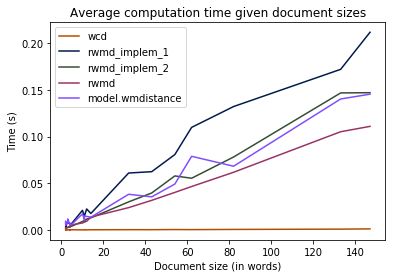

In [134]:
x = data_no_cache[0, 0, :, 1]
fn_names = ["wcd", "rwmd_implem_1", "rwmd_implem_2", "rwmd", "model.wmdistance"]

x_args = np.argsort(x)

fig, ax = plt.subplots()
for i in range(data_no_cache.shape[0]):
    ax.plot(x[x_args], data_no_cache[i, 0, x_args, 0] / 100, 'k', color=np.around(np.random.rand(3, 1), 1).flatten(), label=fn_names[i])
i = len(data) - 1
ax.plot(x[x_args], data[i, 0, x_args, 0] / 100, 'k', color=np.around(np.random.rand(3, 1), 1).flatten(), label=fn_names[i])

ax.legend()

ax.set_xlabel('Document size (in words)')
ax.set_ylabel('Time (s)')
ax.set_title('Average computation time given document sizes')
plt.show()

We can see that *WCD* is clearly ahead in terms of speed.

Then some of the *RWMD* implementations are slower than the original *wmdistance* from *Gensim*.

Let's use distance caching on all implementations and see how that changes things:

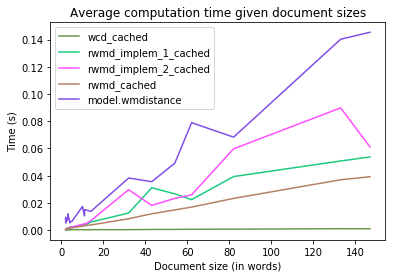

In [119]:
x = data[0, 0, :, 1]
fn_names = ["wcd", "rwmd_implem_1", "rwmd_implem_2", "rwmd", "model.wmdistance"]

x_args = np.argsort(x)

fig, ax = plt.subplots()
for i in range(data.shape[0]):
    ax.plot(x[x_args], data[i, 0, x_args, 0] / 100, 'k', color=np.around(np.random.rand(3, 1), 1).flatten(), label=fn_names[i] + ('' if i == len(fn_names) - 1 else '_cached'))

ax.legend()

ax.set_xlabel('Document size (in words)')
ax.set_ylabel('Time (s)')
ax.set_title('Average computation time given document sizes')
plt.show()

We can now see that all our implementations are **faster than the original *wmdistance* thanks to distance caching**.

Now let's use and bench the final caching algorithm that uses the full distance matrix. This caching actually **uses twice the memory**.

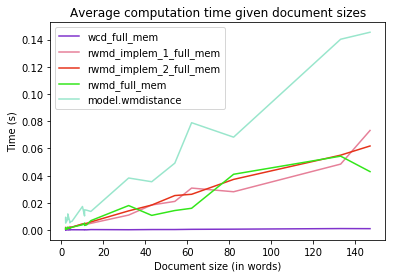

In [136]:
x = data_cache_full_mem[0, 0, :, 1]
fn_names = ["wcd", "rwmd_implem_1", "rwmd_implem_2", "rwmd", "model.wmdistance"]

x_args = np.argsort(x)

fig, ax = plt.subplots()
for i in range(data_cache_full_mem.shape[0]):
    ax.plot(x[x_args], data_cache_full_mem[i, 0, x_args, 0] / 100, 'k', color=np.around(np.random.rand(3, 1), 1).flatten(), label=str(fn_names[i]+ ('' if i == len(fn_names) - 1 else '_full_mem')))
ax.plot(x[x_args], data[-1, 0, x_args, 0] / 100, 'k', color=np.around(np.random.rand(3, 1), 1).flatten(), label=fn_names[-1])

ax.legend()

ax.set_xlabel('Document size (in words)')
ax.set_ylabel('Time (s)')
ax.set_title('Average computation time given document sizes')
plt.show()

We can see that our implementations are getting very close to eachother in terms of performance but the overall speed improvement isn't very noticeable.

Let's do a few final comparisons between cached and non cached and then between the two caching methods:

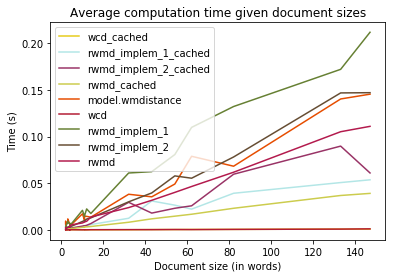

In [139]:
x = data[0, 0, :, 1]
fn_names = ["wcd", "rwmd_implem_1", "rwmd_implem_2", "rwmd", "model.wmdistance"]

x_args = np.argsort(x)

fig, ax = plt.subplots()
for i in range(data.shape[0]):
    ax.plot(x[x_args], data[i, 0, x_args, 0] / 100, 'k', color=np.around(np.random.rand(3, 1), 1).flatten(), label=str(fn_names[i]+ ('' if i == len(fn_names) - 1 else '_cached')))
for i in range(data_no_cache.shape[0]):
    ax.plot(x[x_args], data_no_cache[i, 0, x_args, 0] / 100, 'k', color=np.around(np.random.rand(3, 1), 1).flatten(), label=fn_names[i])

ax.legend()

ax.set_xlabel('Document size (in words)')
ax.set_ylabel('Time (s)')
ax.set_title('Average computation time given document sizes')
plt.show()

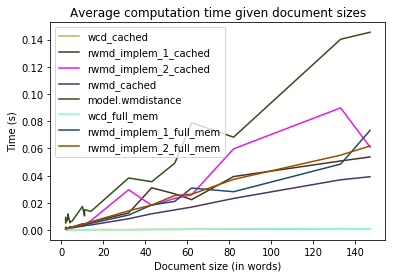

In [141]:
x = data[0, 0, :, 1]
fn_names = ["wcd", "rwmd_implem_1", "rwmd_implem_2", "rwmd", "model.wmdistance"]

x_args = np.argsort(x)

fig, ax = plt.subplots()
for i in range(data.shape[0]):
    ax.plot(x[x_args], data[i, 0, x_args, 0] / 100, 'k', color=np.around(np.random.rand(3, 1), 1).flatten(), label=str(fn_names[i]+ ('' if i == len(fn_names) - 1 else '_cached')))
for i in range(data_cache_full_mem.shape[0] - 1):
    ax.plot(x[x_args], data_cache_full_mem[i, 0, x_args, 0] / 100, 'k', color=np.around(np.random.rand(3, 1), 1).flatten(), label=str(fn_names[i]+ ('' if i == len(fn_names) - 1 else '_full_mem')))

ax.legend()

ax.set_xlabel('Document size (in words)')
ax.set_ylabel('Time (s)')
ax.set_title('Average computation time given document sizes')
plt.show()

## Accuracy

Here we'll discuss the accuracy of the *WMD* implementations.

This function computes the mean and stamdard deviation of the error rate compared to the original *wmdistance*

In [224]:
def calc_dist_err(impl_id, data, wmd_ref):
    y = np.zeros((data.shape[2], 2))
    for i in range(data.shape[2] - 1):
        err = [abs(np.array(data[-1, 1, i, 0]) -  np.array(wmd_ref[impl_id, 1, i, 0]))]
        m = np.mean(err)
        std = np.std(err)
        y[i][0] = m
        y[i][1] = std
    return y

Let's visualize all this:

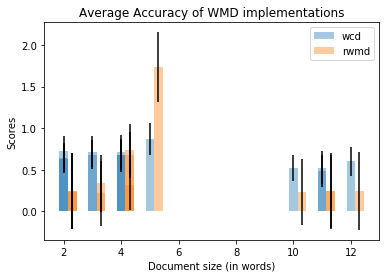

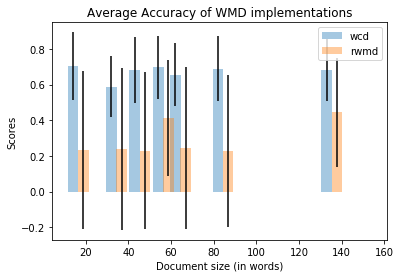

In [261]:
x = data[0, 0, :, 1]
fn_names = ["wcd", "rwmd_implem_1", "rwmd_implem_2", "rwmd", "model.wmdistance"]

x_args = np.argsort(x)
fig, ax = plt.subplots()
fig, ax2 = plt.subplots()
impls = (0, 3)
n = 13
for i in impls:
    y = calc_dist_err(i, data, data)
    ax.bar(x[x_args][:n] + 0.1*i, y[:n,0], 0.3, yerr=y[:n,1],
                alpha=0.4,
                label=fn_names[i])
for i in impls:
    y = calc_dist_err(i, data, data)
    ax2.bar(x[x_args][n:] + 1.6*i, y[n:,0], 5, yerr=y[n:,1],
                alpha=0.4,
                label=fn_names[i])
ax.legend()

ax.set_xlabel('Document size (in words)')
ax.set_ylabel('Scores')
ax.set_title('Average Accuracy of WMD implementations')

ax2.legend()

ax2.set_xlabel('Document size (in words)')
ax2.set_ylabel('Scores')
ax2.set_title('Average Accuracy of WMD implementations')
plt.show()

We can see that the mean error of *WCD* is pretty high compared to *RWMD* but the standard deviation is actually high for the *RWMD* from document to document.

## Multiple documents

This sections compares WMD with Prefetch and Prune to the exact WMD for the task of finding the k nearest documents.

We need a way to compute a score for our accuracy benchmark.

The score is computed by counting every matching element in array $d1$ and array $d2$.

For example: d1 = [0, 5, 13, 21] and d2 = [3, 21, 5, 19] have $5$ and $21$ in common, so the final count of matching elements will be $2$. We call this function $in1d$ (provided by *Numpy*).

The score can then be formulated as:

$$\frac{\sum_{i=1}^{n} in1d(d1, d2)}{n}$$

So we'll be using this score to compare our implementations' accuracy against the *wmdistance* function from *Gensim*

In [22]:
def calc_wmd_score(wmd_nn, wmd_k_first): 
    acc_score = 0
    for d1, d2 in zip(wmd_nn, wmd_k_first):
        d1 = np.array(d1)
        index = np.in1d(d2, d1)
        score = np.sum(index == True) / len(d1)
        acc_score += score
    return acc_score / len(wmd_nn)

We set up the test functions:

In [100]:
def time_func_mul_docs(k_max=3, m_max=3, nb_iter=10):
    timing_data = np.zeros((k_max, m_max, 2))
    
    def f():
        a = np.array([i for i in range(len(strs_proc))])
        wmd_k_first = [[model.wmdistance(strs_proc[idx], strs_proc[j]) for j in a] for idx in range(len(strs_proc))]
        return a[np.argsort(wmd_k_first)]
    
    timing_wmd, ret_wmd = timeit.Timer(f, 'gc.enable()').timeit(number=nb_iter)
    
    for k in range(1, k_max):
        for m in range(1, m_max):
                def f():
                    return [wmd_prefetch_prune(idx, [i for i in range(len(strs_proc))], k, m) for idx in range(len(strs_proc))]
                
                print(k, m, timing_data.shape)
                timing_data[k, m, 0], ret = timeit.Timer(f, 'gc.enable()').timeit(number=nb_iter)
                
                timing_data[k, m, 1] = calc_wmd_score(ret, ret_wmd[:, :k])
                print("score:", timing_data[k, m, :])
    
    return timing_data, timing_wmd

In [67]:
data, timing_wmd = time_func_mul_docs(10, 10, 10)

1 1 (10, 10, 3)
score: 1.0
1 2 (10, 10, 3)
score: 1.0
1 3 (10, 10, 3)
score: 1.0
1 4 (10, 10, 3)
score: 1.0
1 5 (10, 10, 3)
score: 1.0
1 6 (10, 10, 3)
score: 1.0
1 7 (10, 10, 3)
score: 1.0
1 8 (10, 10, 3)
score: 1.0
1 9 (10, 10, 3)
score: 1.0
2 1 (10, 10, 3)
score: 0.8181818181818182
2 2 (10, 10, 3)
score: 0.8181818181818182
2 3 (10, 10, 3)
score: 0.8409090909090909
2 4 (10, 10, 3)
score: 0.8863636363636364
2 5 (10, 10, 3)
score: 0.8863636363636364
2 6 (10, 10, 3)
score: 0.8863636363636364
2 7 (10, 10, 3)
score: 0.8863636363636364
2 8 (10, 10, 3)
score: 0.8863636363636364
2 9 (10, 10, 3)
score: 0.9318181818181818
3 1 (10, 10, 3)
score: 0.7878787878787876
3 2 (10, 10, 3)
score: 0.7878787878787876
3 3 (10, 10, 3)
score: 0.7878787878787876
3 4 (10, 10, 3)
score: 0.8181818181818182
3 5 (10, 10, 3)
score: 0.8181818181818182
3 6 (10, 10, 3)
score: 0.8181818181818182
3 7 (10, 10, 3)
score: 0.8181818181818182
3 8 (10, 10, 3)
score: 0.8181818181818182
3 9 (10, 10, 3)
score: 0.8484848484848485
4

### Accuracy

Let's look at the accuracy of our algorithm:

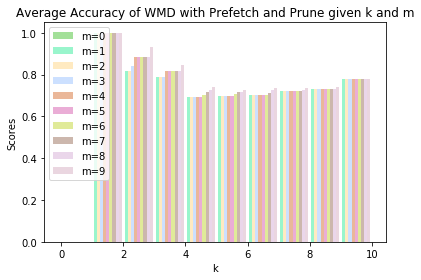

In [115]:
error_config = {'ecolor': '0.3'}
fig, ax = plt.subplots()

for i in range(data.shape[0]):
    ax.bar(np.arange(data.shape[0]) + 0.1*i, data[:, i, 1], 0.1,
                alpha=0.4, color=np.around(np.random.rand(3, 1), 1).flatten(),
                 error_kw=error_config,
                label='m=' + str(i))

ax.legend()

ax.set_xlabel('k')
ax.set_ylabel('Scores')
ax.set_title('Average Accuracy of WMD with Prefetch and Prune given k and m')

fig.tight_layout()
plt.show()

We can clearly see that the accuracy is very acceptable and never dips below $70\%$.

As $k$ grows, it gets less accurate but when $m$ grows, we can compensate a bit this loss of accuracy.

### Computation time

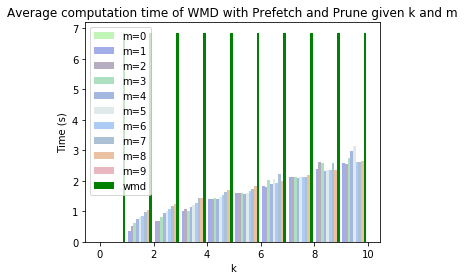

In [116]:
error_config = {'ecolor': '0.3'}
fig, ax = plt.subplots()

for i in range(data.shape[0]):
    ax.bar(np.arange(data.shape[0]) + 0.1*i, data[:, i, 0] / 10, 0.1,
                alpha=0.4, color=np.around(np.random.rand(3, 1), 1).flatten(),
                 error_kw=error_config,
                label='m=' + str(i))

ax.bar(np.arange(data.shape[0]) + 0.1*i, [timing_wmd / 10 for i in range(data.shape[0])], 0.1,
                alpha=1.0, color='g',
                 error_kw=error_config,
                label='wmd')

ax.legend()

ax.set_xlabel('k')
ax.set_ylabel('Time (s)')
ax.set_title('Average computation time of WMD with Prefetch and Prune given k and m')

fig.tight_layout()
plt.show()

We can clearly see that the computation time of our algorithm is way faster than the original *wmdistance* from *Gensim*.

As $k$ and $m$ grow, the computation time grows, but we're still way faster in any case.